In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

In [2]:
!pip install torchinfo -q
from torchinfo import summary

In [3]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.LeakyReLU(0.2,inplace=True)
    )


def double_conv(in_c,out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c,out_c,kernel_size=3),
      nn.BatchNorm2d(out_c),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Conv2d(out_c,out_c,kernel_size=3),
      nn.BatchNorm2d(out_c),
      nn.LeakyReLU(0.2,inplace=True),
  )
  return conv




class Resnet_UNet(nn.Module):
    def __init__(self, out_channels=1):

        super().__init__()

        self.reflect2d = nn.ReflectionPad2d(4)
        self.encoder = models.resnet18()

        self.conv1=list(self.encoder._modules.items())[0][1]
        self.bn1=list(self.encoder._modules.items())[1][1]
        self.relu=list(self.encoder._modules.items())[2][1]
        self.maxpool=list(self.encoder._modules.items())[3][1]

        self.block1=list(self.encoder._modules.items())[4][1]
        self.block2=list(self.encoder._modules.items())[5][1]
        self.block3=list(self.encoder._modules.items())[6][1]
        self.block4=list(self.encoder._modules.items())[7][1]



        self.up_conv6 = up_conv(512,512)
        self.conv6 = double_conv(512+256, 256)

        self.up_conv7 = up_conv(256, 256)
        self.conv7 = double_conv(256 + 128, 128)

        self.up_conv8 = up_conv(128, 128)
        self.conv8 = double_conv(128+64 , 64)

        self.up_conv9 = up_conv(64, 64)
        self.conv9_end= nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x= self.maxpool(x)

        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)



        x = self.up_conv6(block4)
        x = torch.cat([x, block3], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = self.reflect2d(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv7(x)


        x = self.up_conv8(x)
        x = self.reflect2d(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = self.reflect2d(x)
        x = self.conv9_end(x)


        return x

In [4]:

summary(Resnet_UNet(), input_size=(1, 3, 640, 480),
        row_settings=["var_names"],
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
        col_width=16)


Layer (type (var_name))                  Kernel Shape     Output Shape     Param #          Mult-Adds
Resnet_UNet (Resnet_UNet)                --               [1, 1, 320, 240] 513,000          --
├─Conv2d (conv1)                         [7, 7]           [1, 64, 320, 240] 9,408            722,534,400
├─BatchNorm2d (bn1)                      --               [1, 64, 320, 240] 128              128
├─ReLU (relu)                            --               [1, 64, 320, 240] --               --
├─MaxPool2d (maxpool)                    3                [1, 64, 160, 120] --               --
├─Sequential (block1)                    --               [1, 64, 160, 120] --               --
│    └─BasicBlock (0)                    --               [1, 64, 160, 120] --               --
│    │    └─Conv2d (conv1)               [3, 3]           [1, 64, 160, 120] 36,864           707,788,800
│    │    └─BatchNorm2d (bn1)            --               [1, 64, 160, 120] 128              128
│    │    └─ReL

## Utils

In [5]:
import matplotlib
import matplotlib.cm
import numpy as np

def DepthNorm(depth, maxDepth=1000.0):
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin=10, vmax=1000, cmap='plasma'):
    value = value.cpu().numpy()[0,:,:]

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin!=vmax:
        value = (value - vmin) / (vmax - vmin) # vmin..vmax
    else:
        # Avoid 0-division
        value = value*0.
    # squeeze last dim if it exists
    #value = value.squeeze(axis=0)

    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value,bytes=True) # (nxmx4)

    img = value[:,:,:3]

    return img.transpose((2,0,1))

## Load Data

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from io import BytesIO
import random

def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

class RandomHorizontalFlip(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        if not _is_pil_image(image):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth):
            raise TypeError(
                'img should be PIL Image. Got {}'.format(type(depth)))

        if random.random() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

        return {'image': image, 'depth': depth}

class RandomChannelSwap(object):
    def __init__(self, probability):
        from itertools import permutations
        self.probability = probability
        self.indices = list(permutations(range(3), 3))

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if not _is_pil_image(image): raise TypeError('img should be PIL Image. Got {}'.format(type(image)))
        if not _is_pil_image(depth): raise TypeError('img should be PIL Image. Got {}'.format(type(depth)))
        if random.random() < self.probability:
            image = np.asarray(image)
            image = Image.fromarray(image[...,list(self.indices[random.randint(0, len(self.indices) - 1)])])
        return {'image': image, 'depth': depth}

def loadZipToMem(zip_file):
    # Load zip file into memory
    print('Loading dataset zip file...', end='')
    from zipfile import ZipFile
    input_zip = ZipFile(zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    nyu2_train = list((row.split(',') for row in (data['data/nyu2_train.csv']).decode("utf-8").split('\n') if len(row) > 0))

    from sklearn.utils import shuffle
    nyu2_train = shuffle(nyu2_train, random_state=0)

    # if True: nyu2_train = nyu2_train[:40]

    print('Loaded ({0}).'.format(len(nyu2_train)))
    return data, nyu2_train

class depthDatasetMemory(Dataset):
    def __init__(self, data, nyu2_train, transform=None):
        self.data, self.nyu_dataset = data, nyu2_train
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.nyu_dataset[idx]
        image = Image.open( BytesIO(self.data[sample[0]]) )
        depth = Image.open( BytesIO(self.data[sample[1]]) )
        sample = {'image': image, 'depth': depth}
        if self.transform: sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.nyu_dataset)

class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']

        image = self.to_tensor(image)

        depth = depth.resize((320, 240))

        if self.is_test:
            depth = self.to_tensor(depth).float() / 1000
        else:
            depth = self.to_tensor(depth).float() * 1000

        # put in expected range
        depth = torch.clamp(depth, 10, 1000)

        return {'image': image, 'depth': depth}

    def to_tensor(self, pic):
        if not(_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(
                torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img

def getNoTransform(is_test=False):
    return transforms.Compose([
        ToTensor(is_test=is_test)
    ])

def getDefaultTrainTransform():
    return transforms.Compose([
        RandomHorizontalFlip(),
        RandomChannelSwap(0.5),
        ToTensor()
    ])

def getTrainingTestingData(batch_size):
    data, nyu2_train = loadZipToMem('/content/nyu_data.zip')

    transformed_training = depthDatasetMemory(data, nyu2_train, transform=getDefaultTrainTransform())
    transformed_testing = depthDatasetMemory(data, nyu2_train, transform=getNoTransform())

    return DataLoader(transformed_training, batch_size, shuffle=True), DataLoader(transformed_testing, batch_size, shuffle=False)

## Loss

In [8]:
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

## Download and Unzip data

In [9]:
!curl -L -o 'nyu_data.zip' 'https://drive.google.com/u/0/uc?id=1R8ft2bwAuORfzbDezVrGx97_33gv6EfM&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4195M  100 4195M    0     0  74.0M      0  0:00:56  0:00:56 --:--:-- 73.6M


In [10]:
!unzip -q /content/nyu_data.zip

## Train

In [11]:
!pip install tensorboardx -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 16.0 MB/s eta 0:00:00


In [12]:
from tensorboardX import SummaryWriter

def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))
    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))
    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow=6, normalize=True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow=6, normalize=False)), epoch)
    output = DepthNorm( model(image) )
    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow=6, normalize=False)), epoch)
    writer.add_image('Train.3.Diff', colorize(vutils.make_grid(torch.abs(output-depth).data, nrow=6, normalize=False)), epoch)
    del image
    del depth
    del output

In [13]:
import time
import argparse
import datetime

import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils

epochs=10
learning_rate = 0.0001
batch_size =4

# Create model
model = Resnet_UNet().cuda()
print('Model created.')

# Training parameters
optimizer = torch.optim.Adam( model.parameters(), learning_rate )
batch_size = batch_size
prefix = 'resnet_' + str(batch_size)

# Load data
train_loader, test_loader = getTrainingTestingData(batch_size=batch_size)

# Logging
writer = SummaryWriter(comment='{}-lr{}-e{}-bs{}'.format(prefix, learning_rate, epochs, batch_size), flush_secs=30)

# Loss
l1_criterion = nn.L1Loss()

Model created.
Loading dataset zip file...Loaded (50688).


## Start training

In [14]:

# Start training...
for epoch in range(epochs):
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        # Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm( depth )

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim) + (0.1 * l_depth)

        # Update step
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log progress
        niter = epoch*N+i
        if i % 5000 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            writer.add_scalar('Train/Loss', losses.val, niter)

        if i % 1000 == 0:
            LogProgress(model, writer, test_loader, niter)

    # Record epoch's intermediate results
    LogProgress(model, writer, test_loader, niter)
    writer.add_scalar('Train/Loss.avg', losses.avg, epoch)

<ipython-input-7-e40ccf96168d>:118: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  torch.ByteStorage.from_buffer(pic.tobytes()))


Epoch: [0][0/12672]	Time 1.916 (1.916)	ETA 6:44:34	Loss 0.8779 (0.8779)


<ipython-input-5-ad6547184d4f>:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


Epoch: [0][5000/12672]	Time 0.161 (737.878)	ETA 0:20:36	Loss 0.1770 (0.1959)
Epoch: [0][10000/12672]	Time 0.139 (1462.569)	ETA 0:06:12	Loss 0.2056 (0.1780)
Epoch: [1][0/12672]	Time 0.116 (0.116)	ETA 0:24:26	Loss 0.8482 (0.8482)
Epoch: [1][5000/12672]	Time 0.141 (725.032)	ETA 0:18:00	Loss 0.1219 (0.1318)
Epoch: [1][10000/12672]	Time 0.142 (1450.704)	ETA 0:06:18	Loss 0.2076 (0.1219)
Epoch: [2][0/12672]	Time 0.237 (0.237)	ETA 0:50:07	Loss 0.6864 (0.6864)
Epoch: [2][5000/12672]	Time 0.138 (725.632)	ETA 0:17:38	Loss 0.0817 (0.0943)
Epoch: [2][10000/12672]	Time 0.141 (1449.491)	ETA 0:06:18	Loss 0.1174 (0.0887)
Epoch: [3][0/12672]	Time 0.205 (0.205)	ETA 0:43:21	Loss 0.8562 (0.8562)
Epoch: [3][5000/12672]	Time 0.141 (723.544)	ETA 0:17:59	Loss 0.0989 (0.0741)
Epoch: [3][10000/12672]	Time 0.141 (1449.141)	ETA 0:06:17	Loss 0.0671 (0.0709)
Epoch: [4][0/12672]	Time 0.178 (0.178)	ETA 0:37:35	Loss 0.7376 (0.7376)
Epoch: [4][5000/12672]	Time 0.139 (726.423)	ETA 0:17:50	Loss 0.0471 (0.0617)
Epoch: [4][

## testing

In [15]:
# download test data
!wget -q https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip

In [16]:
from zipfile import ZipFile
from skimage.transform import resize

# Load test data
def load_test_data():
    print('Loading test data...', end='')
    def extract_zip(input_zip):
        input_zip=ZipFile(input_zip)
        return {name: input_zip.read(name) for name in input_zip.namelist()}
    data = extract_zip('/content/nyu_test.zip')

    rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
    depth = np.load(BytesIO(data['eigen_test_depth.npy']))
    crop = np.load(BytesIO(data['eigen_test_crop.npy']))

    print(rgb.shape,depth.shape,crop.shape)
    print('Test data loaded.\n')

    return rgb, depth, crop

# def DepthNorm(x, maxDepth):
#     return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):

    # Convert to numpy for operations
    images= torch.from_numpy(images)
    # from NHWC to NCHW
    images = images.permute(0, 3, 1, 2)

    # Support multiple RGBs, one RGB image, even grayscale
    if len(images.shape) < 3:
      images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4:
      images = images.reshape((1, images.shape[0],images.shape[1], images.shape[2]))

    # Set device to Cuda
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model_to = model.to(device)
    input = images.to(device)

    model_to, input = model_to.type(torch.cuda.FloatTensor), input.type(torch.cuda.FloatTensor)
    outputs = model_to(input)

    predictions=outputs
    # from NCHW to NHWC
    predictions = predictions.permute(0, 2, 3,1)

    predictions = predictions.cpu().detach().numpy()
    return np.clip(DepthNorm(predictions, maxDepth=1000), minDepth, maxDepth) / maxDepth



def scale_up(scale, images):
    scaled = []

    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append( resize(img, output_shape, order=1, preserve_range=True, \
                              mode='reflect', anti_aliasing=True ) )

    return np.stack(scaled)

def evaluate(model, rgb, depth, crop, batch_size=6):
    def compute_errors(gt, pred):
        thresh = np.maximum((gt / pred), (pred / gt))

        a1 = (thresh < 1.25   ).mean()
        a2 = (thresh < 1.25 ** 2).mean()
        a3 = (thresh < 1.25 ** 3).mean()

        abs_rel = np.mean(np.abs(gt - pred) / gt)

        rmse = (gt - pred) ** 2
        rmse = np.sqrt(rmse.mean())

        log_10 = (np.abs(np.log10(gt)-np.log10(pred))).mean()

        return a1, a2, a3, abs_rel, rmse, log_10

    depth_scores = np.zeros((6, len(rgb))) # six metrics

    bs = batch_size

    for i in range(len(rgb)//bs):
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]

        pred_y = scale_up(2, predict(model, x/255, minDepth=10, maxDepth=1000, \
                                     batch_size=bs)[:,:,:,0]) * 10.0

        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=10,\
                                          maxDepth=1000, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]

        # Compute errors per image in batch
        for j in range(len(true_y)):
            errors = compute_errors(true_y[j], (0.5 * pred_y[j]) + \
                                    (0.5 * np.fliplr(pred_y_flip[j])))

            for k in range(len(errors)):
                depth_scores[k][(i*bs)+j] = errors[k]

    e = depth_scores.mean(axis=1)

    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}"\
          .format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
    print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}"\
          .format(e[0],e[1],e[2],e[3],e[4],e[5]))

In [17]:
rgb, depth, crop = load_test_data()

Loading test data...(654, 480, 640, 3) (654, 480, 640) (4,)
Test data loaded.



In [18]:
evaluate(model, rgb, depth, crop)

        a1,         a2,         a3,        rel,        rms,     log_10
    0.6183,     0.8761,     0.9605,     0.2386,     0.7808,     0.0964


In [19]:
#   Delta1 Delta2 Delta3      rel   RMSE   log10
#   0.964  0.995  0.999     0.069  0.254  0.030

In [20]:
# Download test image
!wget -q https://github.com/jideilori/DenseDepth/blob/master/examples/119_image.png?raw=true -O img.png

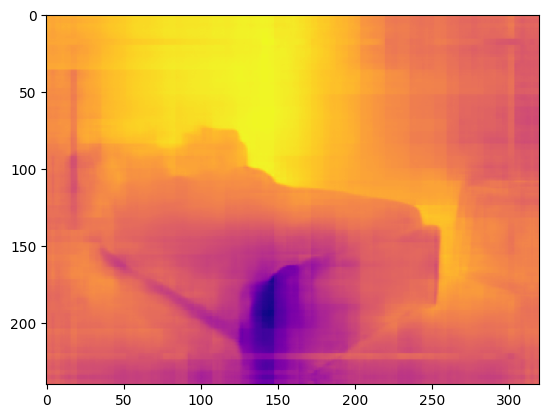

In [22]:
import matplotlib.pyplot as plt
transform = transforms.ToTensor()
# load your image(s)
img = Image.open('/content/img.png')
img = img.resize((640,480))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.eval()

model_to = model.to(device)
input = transform(img)
input = input.to(device)

input = input.unsqueeze(0)
output = model_to(input)

output = output.cpu().detach().numpy().squeeze(1)
depth_map = output.squeeze(0)
plt.imshow(depth_map,cmap='plasma_r');

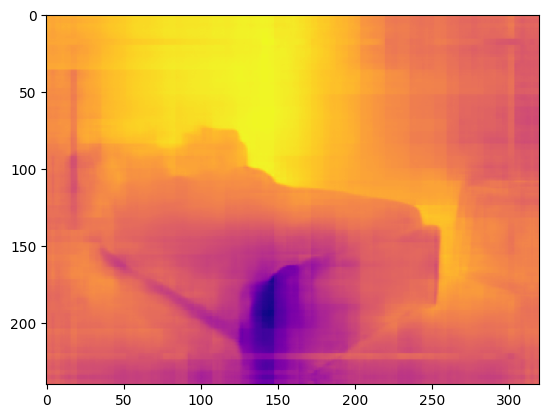

In [26]:
plt.imshow(depth_map,cmap='plasma_r');

In [28]:
!wget -q https://cdn-bnokp.nitrocdn.com/QNoeDwCprhACHQcnEmHgXDhDpbEOlRHH/assets/images/optimized/rev-3e11538/www.decorilla.com/online-decorating/wp-content/uploads/2022/03/modern-office-design-for-a-large-conference-room.jpeg -O office.jpeg

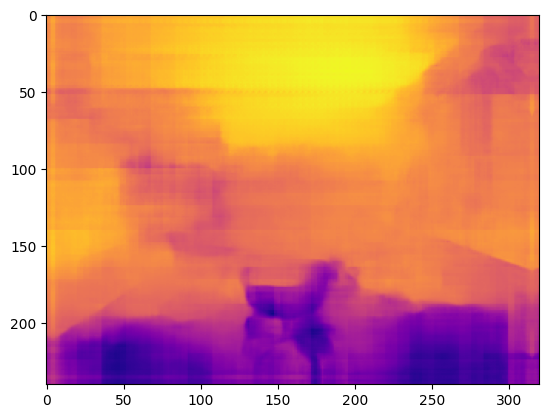

In [29]:
import matplotlib.pyplot as plt
transform = transforms.ToTensor()
# load your image(s)
img = Image.open('/content/office.jpeg')
img = img.resize((640,480))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.eval()

model_to = model.to(device)
input = transform(img)
input = input.to(device)

input = input.unsqueeze(0)
output = model_to(input)

output = output.cpu().detach().numpy().squeeze(1)
depth_map = output.squeeze(0)


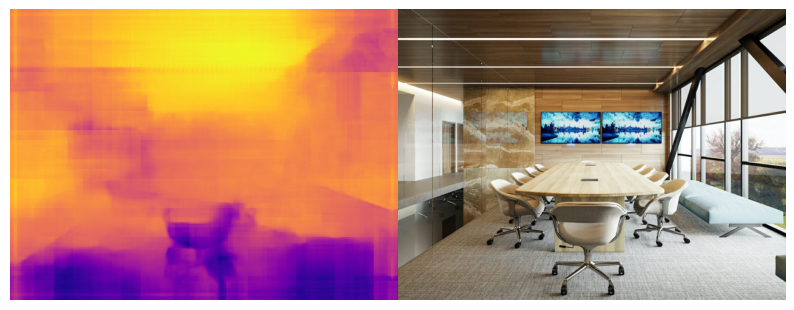

In [35]:
fig,ax = plt.subplots(1,2,figsize=(10,7))

ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(depth_map,cmap='plasma_r');
ax[1].imshow(img);

plt.subplots_adjust(wspace=0.0)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
torch.save(model,'/content/drive/MyDrive/ml_models/resnet_depthnet.pt')

In [25]:
torch.save(model.state_dict(),'/content/drive/MyDrive/ml_models/resnet_depthnet_model_statedict.pt')